In [17]:
from os import listdir
from os.path import join
from pandas import read_csv, concat, MultiIndex
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split

class NFL_data:
    def __init__(self, file_name):
        self.file_list = [file_name]
        self.build_data_frame()
        
    def build_data_frame(self):
        self.nfl_df = read_csv(self.file_list[0],header=[0,1])
        print(self.nfl_df.index.values)
        for index in list(self.nfl_df.index.values):
            if index > 31:
                self.nfl_df.drop(index=index,inplace=True)
        if ('Unnamed: 0_level_0',     'Tm') in self.nfl_df.columns:
            self.nfl_df.sort_values(('Unnamed: 0_level_0',     'Tm'),inplace=True)
            self.nfl_df.drop(columns=[('Unnamed: 0_level_0',     'Tm')],inplace=True)
        elif ('Unnamed: 0_level_0',     'Rk') in self.nfl_df.columns and ('Unnamed: 2_level_0',      'G') in self.nfl_df.columns:
            self.nfl_df.sort_values(('Unnamed: 1_level_0',     'Tm'),inplace=True)
            self.nfl_df.drop(columns=[('Unnamed: 0_level_0',     'Rk'), ('Unnamed: 2_level_0',      'G')],inplace=True)
        tmp_file_list = []
        for i in range(len(self.nfl_df.columns)):
            tmp_file_list.append(self.file_list[0])
        self.nfl_df.columns = MultiIndex.from_tuples(list(zip(tmp_file_list, self.nfl_df.columns)))
        self.nfl_df.reset_index(drop=True,inplace=True)
        
    def add_to_data_frame(self,file_name):
        self.file_list.append(file_name)
        df = read_csv(file_name,header=[0,1])
        for index in list(df.index.values):
            if index > 31:
                df.drop(index=index,inplace=True)
        if ('Unnamed: 0_level_0',     'Tm') in df.columns:
            df.sort_values(('Unnamed: 0_level_0',     'Tm'),inplace=True,ignore_index=True)
            df.drop(columns=[('Unnamed: 0_level_0',     'Tm')],inplace=True)
        elif ('Unnamed: 0_level_0',     'Rk') in df.columns and ('Unnamed: 2_level_0',      'G') in df.columns and ('Unnamed: 1_level_0',     'Tm') in df.columns:
            df.sort_values(('Unnamed: 1_level_0',     'Tm'),inplace=True,ignore_index=True)
            df.drop(columns=[('Unnamed: 0_level_0','Rk'), ('Unnamed: 2_level_0','G'), ('Unnamed: 1_level_0',     'Tm')],inplace=True)
        tmp_file_list = []
        for i in range(len(df.columns)):
            tmp_file_list.append(file_name)
        df.columns = MultiIndex.from_tuples(list(zip(tmp_file_list, df.columns)))
        df.reset_index(drop=True,inplace=True)
        self.nfl_df = concat([self.nfl_df,df],axis=1)

    
        
    def linear_regression_model(self,df_win_rate):
        count = 0
        for col in self.nfl_df.columns:
            if count == 0:
                count += 1
                continue
            filtered_percentages = self.nfl_df[col].astype(str).str.contains('%') #self.nfl_df['%' in self.nfl_df[col]]
            for i in range(len(filtered_percentages)):
                if filtered_percentages.iloc[i]:
                    self.nfl_df[col].iloc[i] = float(self.nfl_df[col].iloc[i].replace('%','')) / 100.0
                
            filtered_percentages = self.nfl_df[col].astype(str).str.contains('Own')
            for i in range(len(filtered_percentages)):
                if filtered_percentages.iloc[i]:
                    self.nfl_df[col].iloc[i] = float(self.nfl_df[col].iloc[i].replace('Own ','-'))
                
            filtered_percentages = self.nfl_df[col].astype(str).str.contains(':')
            for i in range(len(filtered_percentages)):
                if filtered_percentages.iloc[i]:
                    try:
                        self.nfl_df.drop(columns=col,inplace=True)
                    except:
                        pass
                    
        #self.nfl_df.drop(columns=[('D:NFL data for data mining/Data csv/2020\\DriveAverageAgainst.txt', ('Average Drive', 'Time'))],inplace=True)
            #if '%' in col[1][1]:
            #    print(col)
            #    self.nfl_df[col] = self.nfl_df[col].astype(str).str.replace('%','').astype('float') / 100.0
        self.nfl_df = concat([self.nfl_df,df_win_rate[df_win_rate.columns[-1]]],axis=1)
        
        self.nfl_df.sample(1).reset_index(drop=True,inplace=True)
        self.nfl_df.dropna(axis=1,inplace=True)
        self.teams = self.nfl_df.iloc[:,0]
        self.nfl_df.drop(columns=self.nfl_df.columns[0],inplace=True)
        self.y = self.nfl_df.iloc[:,-1]
        self.X = self.nfl_df.iloc[:,1:-1].astype('float')
        
        corr_matrix = self.X.corr().abs()
        corr_columns = self.X.columns
        threshold = 0.5
        filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)] 
        
        to_drop = [column for column in corr_matrix.columns if any(corr_matrix[column] > 0.5)]
        self.X.drop(to_drop, axis=1, inplace=True)
                
        ss = StandardScaler()
        self.X = ss.fit_transform(self.X)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size=0.2)
        logisticRegr = LinearRegression()
        logisticRegr.fit(self.x_train, self.y_train)
        print(logisticRegr.predict(self.x_test))

        
        
directory = 'D:NFL data for data mining/Data csv/2020'
file_list = listdir(directory)
nfl_data = NFL_data(join(directory,file_list[2]))

df_win_rate = read_csv('D:NFL data for data mining/2020_NFL_Win_Rate.csv',header=[0,1])
df_win_rate.sort_values(df_win_rate.columns[0],inplace=True)
df_win_rate.reset_index(drop=True,inplace=True)

count = 0
for file in file_list[3:]:
    if 'NFC' in file and count == 0:
        count += 1
        continue
    if 'AFC' in file or 'NFC' in file or 'Weekly' in file or 'Playoff' in file:
        continue
    print(file)
    nfl_data.add_to_data_frame(join(directory,file))
        
    #break
    
nfl_data.linear_regression_model(df_win_rate)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
Conversions - Defense.txt
Conversions.txt
Defense-vs-QB.txt
Defense-vs-RB.txt
Defense-vs-TE.txt
Defense-vs-WR.txt
DriveAverageAgainst.txt
Kicking_Punting.txt
KickPuntAgainst.txt
Kick_Punt_return.txt
Offense Drive Averages.txt
PassingDefense.txt
Passing_offense.txt
PuntKickReturn - Defense.txt
RushingDefense.txt
Rushing_offense.txt
Scoring_Defense.txt
Scoring_Offense.txt
Team - AdvancedDefense.txt
Team Offense - per game.txt
Team_defense.txt
Team_offense.txt


C:\Users\sebas\Anaconda3\envs\python3_8\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


[0.4825 0.4825 0.4825 0.4825 0.4825 0.4825 0.4825]


In [16]:
print(nfl_data.teams)

0            Arizona Cardinals
1              Atlanta Falcons
2             Baltimore Ravens
3                Buffalo Bills
4            Carolina Panthers
5                Chicago Bears
6           Cincinnati Bengals
7             Cleveland Browns
8               Dallas Cowboys
9               Denver Broncos
10               Detroit Lions
11           Green Bay Packers
12              Houston Texans
13          Indianapolis Colts
14        Jacksonville Jaguars
15          Kansas City Chiefs
16           Las Vegas Raiders
17        Los Angeles Chargers
18            Los Angeles Rams
19              Miami Dolphins
20           Minnesota Vikings
21        New England Patriots
22          New Orleans Saints
23             New York Giants
24               New York Jets
25         Philadelphia Eagles
26         Pittsburgh Steelers
27         San Francisco 49ers
28            Seattle Seahawks
29        Tampa Bay Buccaneers
30            Tennessee Titans
31    Washington Football Team
Name: (D

In [3]:
print(nfl_data.nfl_df.columns)
print(nfl_data.file_list)

MultiIndex([( 'Unnamed: 1_level_0',     'Tm'),
            (              'Downs',  '3DAtt'),
            (              'Downs', '3DConv'),
            (              'Downs',    '3D%'),
            (              'Downs',  '4DAtt'),
            (              'Downs', '4DConv'),
            (              'Downs',    '4D%'),
            (           'Red Zone',  'RZAtt'),
            (           'Red Zone',   'RZTD'),
            (           'Red Zone',  'RZPct'),
            ...
            (            'Rushing',    'Yds'),
            (            'Rushing',     'TD'),
            (            'Rushing',    'Y/A'),
            (            'Rushing',   '1stD'),
            (          'Penalties',    'Pen'),
            (          'Penalties',    'Yds'),
            (          'Penalties',  '1stPy'),
            ('Unnamed: 25_level_0',    'Sc%'),
            ('Unnamed: 26_level_0',    'TO%'),
            ('Unnamed: 27_level_0',    'EXP')],
           length=360)
['D:NFL data for dat

<ipython-input-4-6bab671995ab>:12: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


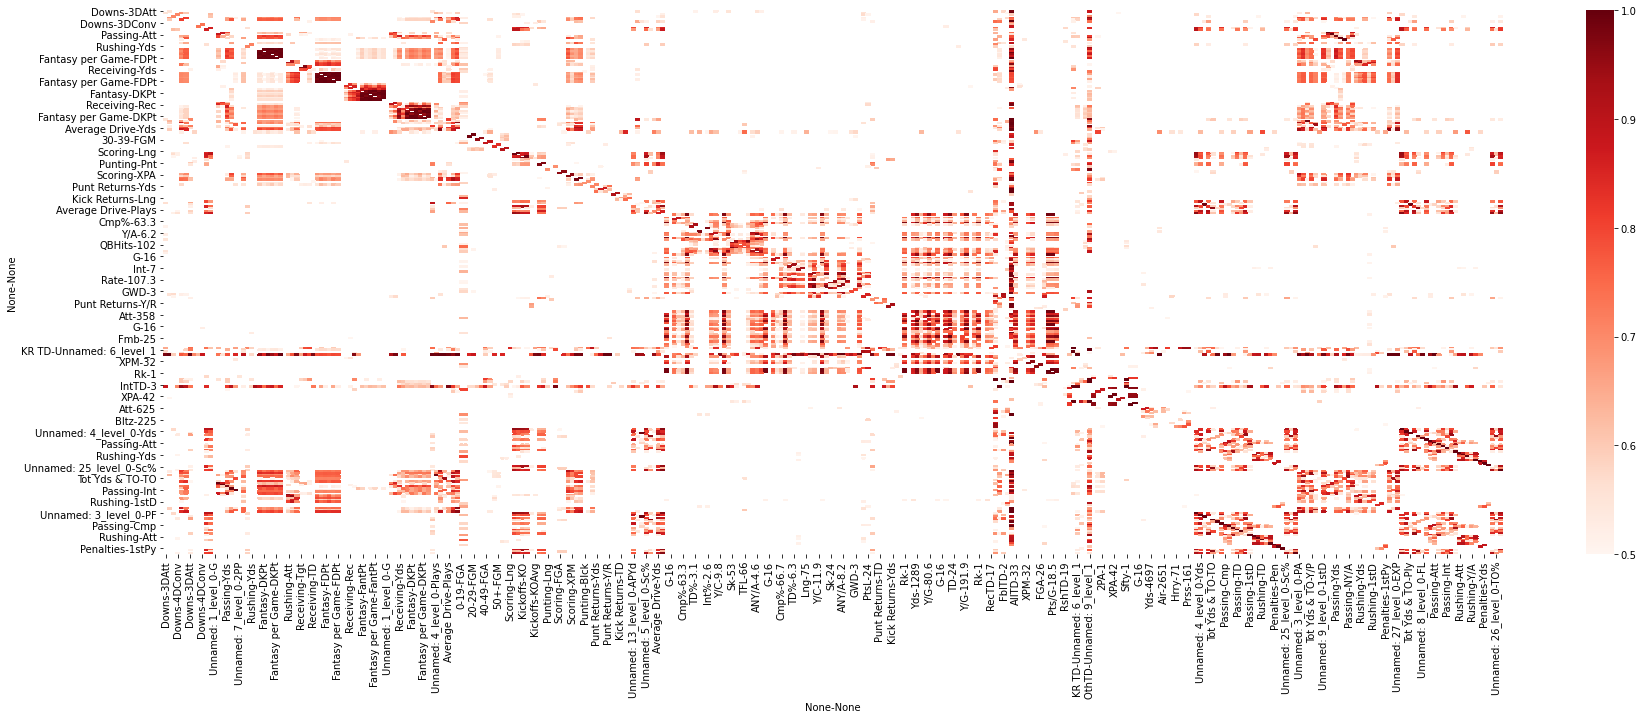

In [4]:
from seaborn import heatmap
from matplotlib.pylab import figure 

corr_matrix = nfl_data.nfl_df.corr().abs()

threshold = 0.5

filtered_corr_df = corr_matrix[(corr_matrix >= threshold) & (corr_matrix != 1.000)] 

fig = figure(figsize=(30,10))
dataplot = heatmap(filtered_corr_df, cmap="Reds")
fig.show()

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer,MinMaxScaler,StandardScaler


logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)

